#integration

In [ ]:
import scanpy as sc, numpy as np, pandas as pd
import seaborn as sns
from scipy.stats import median_abs_deviation
import scvi

In [ ]:
scvi.settings.seed = 0

In [ ]:
import torch
print(torch.cuda.is_available())

In [ ]:
from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt

In [ ]:
import os
os.environ["R_HOME"] = "/data/User/revolvefire/miniforge3/envs/rpy_base_240331/lib/R"
os.environ['LD_LIBRARY_PATH'] = "/data/User/revolvefire/miniforge3/envs/rpy_base_240331/lib/R/bin"

In [ ]:
import anndata2ri
import logging

In [ ]:
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
print(ro.r(".libPaths()"))

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
from time import gmtime, strftime
strftime("%Y-%m-%d %H:%M:%S", gmtime())

In [ ]:
mainDir = "/mnt/gmi-l1/_90.User_Data/revolvefire/fastq/PPP_GMI"

In [ ]:
objectDir = "/mnt/gmi-l1/_90.User_Data/revolvefire/projects/3.PPP_231118/231128_PPP/scobject/"

## Preprocessing

In [ ]:
PPP_PL = sc.read_h5ad(objectDir + "PPP_PL_quality_control_240718_contamfraction0.2.h5ad")
PPP_NPL = sc.read_h5ad(objectDir + "PPP_NPL_quality_control_240718_contamfraction0.2.h5ad")
PPP_3PL = sc.read_h5ad(objectDir + "PPP_3PL_quality_control_240718_contamfraction0.4.h5ad")
PPP_3NPL = sc.read_h5ad(objectDir + "PPP_3NPL_quality_control_240718_contamfraction0.2.h5ad")
Sole_1 = sc.read_h5ad(objectDir + "Sole_1_quality_control_240718_contamfraction0.2.h5ad")
Sole_2 = sc.read_h5ad(objectDir + "Sole_2_quality_control_240718_contamfraction0.2.h5ad")
Sole_3 = sc.read_h5ad(objectDir + "PPP_Control_quality_control_240718_contamfraction0.2.h5ad")

In [ ]:
PPP_PL.obs["bulk_ident"] = "PPP"
PPP_NPL.obs["bulk_ident"] = "PPP"
PPP_3PL.obs["bulk_ident"] = "PPP"
PPP_3NPL.obs["bulk_ident"] = "PPP"
Sole_1.obs["bulk_ident"] = "HC"
Sole_2.obs["bulk_ident"] = "HC"
Sole_3.obs["bulk_ident"] = "HC"

In [ ]:
adata =PPP_PL.concatenate(PPP_NPL, PPP_3PL, PPP_3NPL, Sole_1, Sole_2, Sole_3)
adata.var_names_make_unique()

In [ ]:
adata

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=False, groupby = "orig.ident")

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', groups='batch')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', groups="batch")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata = adata[adata.obs.total_counts > 2000, :]
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs.pct_counts_ribo > 5, :]

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=False, groupby = "orig.ident")

In [ ]:
cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [ ]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'orig.ident')

In [ ]:
adata

In [ ]:
adata.layers["counts"] = adata.X.copy() 

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata 

In [ ]:
adata

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch"
)
adata
adata.var

In [ ]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [ ]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

In [ ]:
adata_scvi = adata_hvg.copy()

In [ ]:
adata_scvi

## scVI training

In [ ]:
scvi.model.SCVI.setup_anndata(adata_scvi,
                              layer="counts", batch_key='batch', categorical_covariate_keys=["bulk_ident4"],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo', 'total_counts'])                       
vae = scvi.model.SCVI(adata_scvi, n_layers=2, n_latent=10, n_hidden=64, gene_likelihood="nb") 
vae.train(check_val_every_n_epoch=5, early_stopping=True) 

In [ ]:
#vae.save("240806.controlincluded.default.seed0.NEWBASE.model",overwrite=False) 

In [ ]:
adata_scvi.obsm["X_scVI"] = vae.get_latent_representation()

In [ ]:
adata_scvi.layers["scvi_normalized"] = vae.get_normalized_expression(
    library_size=10e4
)
adata_scvi

In [ ]:
sc.tl.pca(adata_scvi)
sc.pp.neighbors(adata_scvi, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata_scvi, min_dist=0.4)

In [ ]:
sc.pl.umap(
    adata_scvi,
    color=["orig.ident"],
    frameon=False,
)

In [ ]:
sc.pl.umap(
    adata_scvi,
    color=['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score'],
    ncols=3,
    frameon=False,
)


In [ ]:
adata_scvi

In [ ]:
adata.obsm["X_scVI"] = adata_scvi.obsm["X_scVI"]

In [ ]:
adata.obsm["scvi_normalized"] = adata_scvi.layers["scvi_normalized"]

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=35)
sc.tl.umap(adata, min_dist=0.3)

sc.pl.umap(
    adata,
    color=["orig.ident"],
    frameon=False,
)


/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/rpy_base_240331/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/rpy_base_240331/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/rpy_base_240331/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/rpy_base_240331/

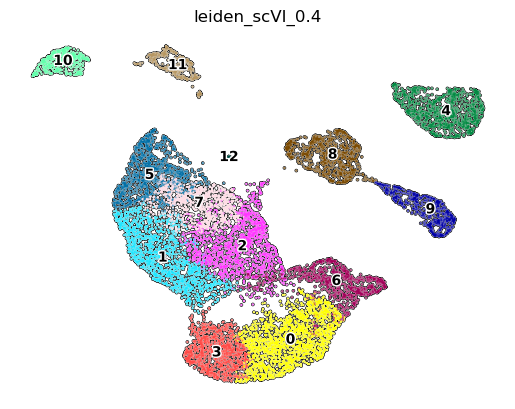

In [100]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.4", resolution=0.4)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.4"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)